In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error


%matplotlib inline
# plt.style.use('seaborn')
%cd C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data

C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data


In [2]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In [6]:
hitters = pd.read_csv('Hitters.csv').dropna()
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


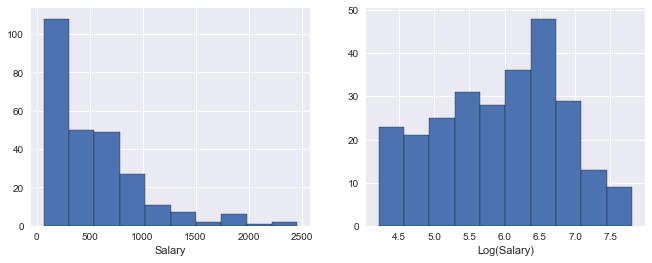

In [27]:
X = hitters[['Years', 'Hits']].as_matrix()
y = np.log(hitters.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.as_matrix(),edgecolor='black')
ax1.set_xlabel('Salary')
ax2.hist(y,edgecolor='black')
ax2.set_xlabel('Log(Salary)');

In [28]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [29]:
graph = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

AttributeError: 'list' object has no attribute 'create_png'

In [30]:
 8 + 7

15